In [1]:
# Google Colab Only
try:
    import base64
    import io
    import json

    import google.colab  # noqa: F401
    import torch

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia

    # Code below is to download the pretrained model weights stored on github
    !mkdir models
    !curl -o gitlfsbinary https://api.github.com/repos/aria-ml/dataeval/git/blobs/ad520d5589fdc49830f98d28aa5eaed0bbdfe5cb

    with open("gitlfsbinary") as f:
        rawfile = json.load(f)

    binaryfile = base64.b64decode(rawfile["content"])
    buffer = io.BytesIO(binaryfile)

    temp = torch.load(buffer, weights_only=False)
    torch.save(temp, "models/ae")

    del rawfile
    del binaryfile
    del buffer
    del temp
except Exception:
    pass

%pip install -q tabulate

/dataeval/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from maite_datasets.image_classification import MNIST
from sklearn.manifold import TSNE

from dataeval.data import Embeddings, Metadata, Select
from dataeval.data.selections import Limit
from dataeval.metrics.bias import coverage

In [3]:
# Set seeds
torch.manual_seed(14)

transforms = [
    lambda x: x / 255.0,  # scale to [0, 1]
    lambda x: (x - 0.1307) / 0.3081,  # normalize
    lambda x: x.astype(np.float32),  # convert to float32
]

# MNIST with mean 0 unit variance
train_ds = MNIST(root="./data", image_set="train", transforms=transforms, download=True)

# Select a subset of the dataset
subset = Select(train_ds, Limit(2000))

In [4]:
# Define model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        return x

In [5]:
# The trained autoencoder was trained for 1000 epochs
sd = torch.load("models/ae", weights_only=True)
model = Autoencoder()
model.load_state_dict(sd)

<All keys matched successfully>

In [6]:
# Calculate the embeddings and extract the labels from the dataset
embeddings = Embeddings(subset, batch_size=64, model=model).to_tensor()
labels = Metadata(subset).class_labels

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
# Visualize 10d as 2d with TSNE
tsne = TSNE(n_components=2)
red_dim = tsne.fit_transform(embeddings.cpu().numpy())

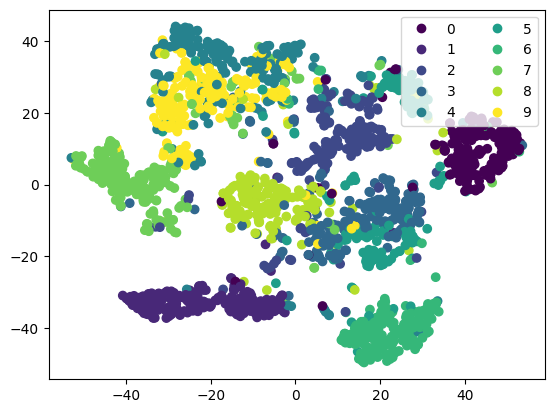

In [8]:
# Plot results with color being label
fig, ax = plt.subplots()
scatter = ax.scatter(
    x=red_dim[:, 0],
    y=red_dim[:, 1],
    c=labels,
    label=labels,
)
ax.legend(*scatter.legend_elements(), loc="upper right", ncols=2)
plt.show()

In [9]:
# Use data adaptive cutoff
cvrg = coverage(embeddings, radius_type="adaptive")

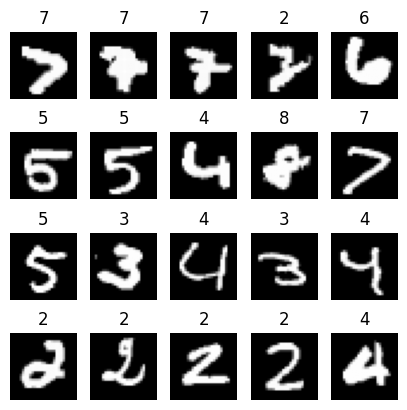

In [10]:
# Plot the least covered 1%
f, axs = plt.subplots(4, 5, figsize=(5, 5))
axs = axs.flatten()
for count, i in enumerate(axs):
    idx = cvrg.uncovered_indices[count]
    i.imshow(np.squeeze(train_ds[idx][0]), cmap="gray")
    i.set_axis_off()
    i.title.set_text(int(labels[idx]))

In [11]:
### TEST ASSERTION CELL ###
wonky = sum(labels[i] == 2 or labels[i] == 7 for idx, i in enumerate(cvrg.uncovered_indices) if idx < 20)
print(wonky)
assert (wonky / 20) > 0.4

9
